# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [13]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [14]:
env = UnityEnvironment(file_name="./Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [15]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [16]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
step_count = 1
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    step_count+=1
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score)," steps ",step_count)

When finished, you can close the environment.

env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import random

In [18]:
EPISODES = 999999 #
MAX_STEPS = 200000
START_EPSILON = 1.0
END_EPSILON = 0.01
EPSILON_DECAY = 0.990
UPDATE_TARGET_NETWORK_EVERY = 50
REPLAY_BUFFER_SIZE = 100000
TRAIN_EVERY  = 4
BATCH_SIZE = 32
PRINT_EVERY = 10
LEARNING_RATE = 0.00025
VISUALIZE_EVERY = 100 #visualize the agent in the unity environment

DESIRED_AVERAGE = 13
DESIRED_EPISODES_AVERAGE = 100

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [20]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples for experience replay"""

    def __init__(self, action_size, buffer_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        #self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self,batch_size):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [21]:
class QNetwork(nn.Module):
    def __init__(self,state_size,action_size):
        super(QNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        #assert len(hidden_sizes) > 0
        self.fc1 = nn.Linear(state_size,150)
        #self.hidden_layers = [] # list of nn.Linear
        
        #for i,size in enumerate(hidden_sizes[1:]):
        #    self.hidden_layers.append(nn.Linear(hidden_sizes[i],size))
         
        self.fc2 = nn.Linear(150,150)
        self.output_layer = nn.Linear(150,action_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
            
        x = self.output_layer(x)
        
        return x

In [22]:
action_size

4

In [23]:
class Agent():
    
    def __init__(self,state_size, action_size,lr=0.001):
        print("agent created")
        self.action_size = action_size
        self.q_network_local = QNetwork(state_size,action_size).to(device) #network used to make desicion and with online updates
        self.q_network_target = QNetwork(state_size,action_size).to(device) #network to calclate the target (copy of local)
        self.q_network_target.eval()
        self.optimizer = optim.Adam(self.q_network_local.parameters(),lr =lr) #TODO:ADD lr as parameter
        
        self.replay_buffer = ReplayBuffer(action_size,REPLAY_BUFFER_SIZE) #TODO: make them variables of constructor
        
        self.explore_count = 0
        self.exploit_count = 0
        
    def act(self,state,epsilon=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        random_sampled = np.random.random()
        
        #explore
        if random_sampled <= epsilon:
            action = np.random.randint(action_size)
            self.explore_count += 1 
        else: #exploit
            self.q_network_local.eval()
            with torch.no_grad():
                q_values = self.q_network_local(state)
                
            greedy_action = np.argmax(q_values.cpu().data.numpy())   
            action = greedy_action
            self.exploit_count += 1

        return action
    
    def update_target_network(self):
        for target_param, local_param in zip(self.q_network_target.parameters(), self.q_network_local.parameters()):
            target_param.data.copy_(local_param.data )
            
    def train(self,batch_size):
        (states, actions, rewards, next_states, dones) = self.replay_buffer.sample(batch_size)
        
        
        with torch.no_grad():
            local_max_action = self.q_network_local(next_states).detach().argmax(1).unsqueeze(1)
            current_target  = rewards + 0.99*self.q_network_target(next_states).gather(dim=1,index=local_max_action)
            
        self.q_network_local.train()
        current_estimate =  self.q_network_local(states).gather(1,actions)
        
        mse_loss = F.mse_loss(current_target,current_estimate)
        self.optimizer.zero_grad()
        mse_loss.backward()
        self.optimizer.step()
        
    def reset_explore_exploit_counts(self):
        self.explore_count = 0
        self.exploit_count = 0
        
    def get_explore_explit_counts(self):
        return str((self.explore_count,self.exploit_count))

In [24]:
#env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")
agent = Agent(state_size,action_size,LEARNING_RATE)

episodes_rewards = []
solved = False
epsilon = START_EPSILON
for episode in range(EPISODES):
    finished = False
    step_count = 0
    episode_score = 0
    
    agent.reset_explore_exploit_counts()
    
    train_mode = not (episode % VISUALIZE_EVERY == 0)
    env_info = env.reset(train_mode=train_mode)[brain_name]
    state = env_info.vector_observations[0]
    
    while not finished: #and step_count < MAX_STEPS:
        action = agent.act(state,epsilon) 

        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        finished = env_info.local_done[0]
        
        # add experience tuple to experience replay buffer
        agent.replay_buffer.add(state,action,reward,next_state,finished)
        episode_score += reward
        state = next_state
        
        # create a copy of local network to target network
        if step_count % UPDATE_TARGET_NETWORK_EVERY == 0:
            agent.update_target_network()
            
            
        if step_count % TRAIN_EVERY == 0 and len(agent.replay_buffer) >=  BATCH_SIZE:
            agent.train(BATCH_SIZE)
            
        step_count += 1
        
    if episode % PRINT_EVERY == 0:
        print("Episode:",episode, " steps:",step_count, " episode reward:",episode_score, " epsilon:",epsilon," explore,exploit counts:",agent.get_explore_explit_counts())
    
    episodes_rewards.append(episode_score)
    last_n_episode_rewards = np.mean(episodes_rewards[-DESIRED_EPISODES_AVERAGE:])
    
    if last_n_episode_rewards >= DESIRED_AVERAGE:
        print("Solved in ",episode, " episodes ")
        checkpoint_name = "checkpoint_solved_"+str(episode)+".pth"
        torch.save(agent.q_network_local.state_dict(), checkpoint_name)
        solved = True
        break
    
    epsilon = max(END_EPSILON, EPSILON_DECAY*epsilon)
    
if not solved:
    checkpoint_name = "checkpoint_not_solved_"+str(episode)+".pth"
    torch.save(agent.q_network_local.state_dict(), checkpoint_name)

print("Last ", DESIRED_EPISODES_AVERAGE," average reward:",last_n_episode_rewards)


agent created
Episode: 0  steps: 300  episode reward: 0.0  epsilon: 1.0  explore,exploit counts: (300, 0)
Episode: 10  steps: 300  episode reward: 0.0  epsilon: 0.9043820750088043  explore,exploit counts: (273, 27)
Episode: 20  steps: 300  episode reward: -1.0  epsilon: 0.8179069375972307  explore,exploit counts: (247, 53)
Episode: 30  steps: 300  episode reward: -1.0  epsilon: 0.7397003733882802  explore,exploit counts: (224, 76)
Episode: 40  steps: 300  episode reward: 0.0  epsilon: 0.6689717585696803  explore,exploit counts: (200, 100)
Episode: 50  steps: 300  episode reward: 0.0  epsilon: 0.6050060671375365  explore,exploit counts: (183, 117)
Episode: 60  steps: 300  episode reward: 0.0  epsilon: 0.5471566423907612  explore,exploit counts: (164, 136)
Episode: 70  steps: 300  episode reward: 1.0  epsilon: 0.49483865960020695  explore,exploit counts: (156, 144)
Episode: 80  steps: 300  episode reward: 2.0  epsilon: 0.44752321376381066  explore,exploit counts: (139, 161)
Episode: 90  

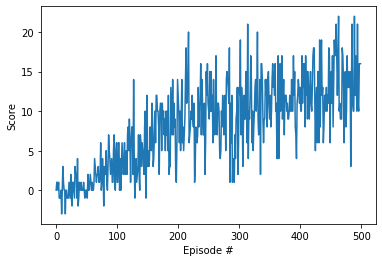

In [25]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episodes_rewards)), episodes_rewards)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### See it trained

In [27]:
env = UnityEnvironment(file_name="./Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

OSError: handle is closed

ERROR:root:Exception calling application: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/llealhernandez/anaconda/envs/drlnd/lib/python3.6/site-packages/grpc/_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "/Users/llealhernandez/anaconda/envs/drlnd/lib/python3.6/site-packages/unityagents/rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "/Users/llealhernandez/anaconda/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/Users/llealhernandez/anaconda/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/llealhernandez/anaconda/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]